In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
tf.random.set_seed(2345)

path="../input/datacsv/data.csv"
data=pd.read_csv(path)
data_new= data.drop('date time',1)
data_new=data_new.iloc[:,0:37] #为了避免42和58等的异常大edc负载值，取37个edc中心作为实验对象


#读data_new
#path2='./data_new.csv'
#data_new=pd.read_csv(path2)


In [3]:
data_new


,1,2,3,4,5,6,7,8,9,10,...,28,29,30,31,32,33,34,35,36,37
0,12,5,9,26,5,12,0,8,11,8,...,5,5,5,12,13,15,21,13,6,6
1,30,19,48,72,13,32,2,17,27,44,...,10,15,12,43,26,39,65,40,24,12
2,18,22,69,72,23,30,4,27,23,54,...,9,14,11,48,27,60,69,44,22,15
3,20,21,75,59,27,37,1,29,23,55,...,10,17,18,46,28,52,80,38,31,17
4,36,22,62,78,16,35,4,36,28,50,...,11,14,15,58,28,51,84,41,31,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,18,11,23,34,16,21,2,20,18,25,...,17,15,14,42,15,25,17,18,24,16
1774,15,14,25,33,16,21,2,17,13,21,...,14,16,9,43,25,31,22,15,22,20
1775,13,11,24,32,22,22,2,16,14,28,...,18,16,10,35,26,26,33,16,22,16
1776,9,12,25,28,14,24,1,16,20,19,...,14,10,7,29,23,33,32,19,15,15


In [ ]:
"""""""""""""""""""""""""""""""""
数据分析部分
画出数据箱线图
参考https://www.cnblogs.com/LiErRui/articles/11588718.html
"""""""""""""""""""""""""""""""""
# 绘制箱线图
plt.figure(figsize=(12,8),dpi=600)
plt.boxplot(x = data_new, # 指定绘图数据
            labels = data_new.columns, # 添加x轴的刻度标签
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
            showmeans=True, # 以点的形式显示均值
            boxprops = {'color':'black','facecolor':'steelblue'}, # 设置箱体属性，如边框色和填充色
            # 设置异常点属性，如点的形状、填充色和点的大小
            flierprops = {'marker':'o','markerfacecolor':'red', 'markersize':3},
            # 设置均值点的属性，如点的形状、填充色和点的大小
            meanprops = {'marker':'D','markerfacecolor':'indianred', 'markersize':4},
            # 设置中位数线的属性，如线的类型和颜色
            medianprops = {'linestyle':'--','color':'orange'},
            #labels = [''] # 删除x轴的刻度标签，否则图形显示刻度标签为1
           )
# 添加图形标题

plt.title('cpu load of 37 edc ')
# 显示图形
plt.show()


In [ ]:
#每个数据中心的总负载
CpuLoad=list()
for i in range(1,38):  #1-37
    CpuLoad.append(data.iloc[:,i].sum())
plt.figure(figsize=(12,8),dpi=600)
plt.plot(CpuLoad)
CpuLoad=pd.DataFrame(CpuLoad)

In [ ]:
#每列是一个数据中心的任务负载时间序列，先看看
plot_cols=['1','20','37']
plot_features = data[plot_cols]
plot_features.index = data['date time']
_ = plot_features.plot(figsize=(12,8),subplots=True)

plot_features = data[plot_cols][:480]
plot_features.index = data['date time'][:480]
_ = plot_features.plot(figsize=(12,8),subplots=True)


#plt.plot(data.iloc[:,5])

In [ ]:
#画柱状图
plt.figure(figsize=(12, 8),dpi=600)
plt.bar(CpuLoad.index,CpuLoad[0], color =  'g', align =  'center') 
plt.title('Bar graph') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
训练数据的构造部分

"""""""""""""""""""""""""""""""""""""""""""""""""""

#处理数据归一化，确定训练集和测试集
def get_window_data(data,window,edcs,preID,test_split):
    """""""""""""""""""""""
    input:  data   数据
            window 窗口长度
            edcs   作为神经网络模型输入的最为预测基础的edc的ID-1
            preID  作为神经网络模型输出的需要预测的edc的ID-1  
            test_split 分割系数
    return: x_train,y_train,x_test,y_test
            
    """""""""""""""""""""""
    #下面六行可删除
    #归一化，min-max归一化 后在0-1之间
    #data_new = data.drop('date time',1) #数据除去日期非数值列准备归一化，
    ###data_norm = (data_new - data_new.min()) / (data_new.max() - data_new.min())# 数值在0-1之间
    #data=scaler.fit_transform(data_new.reshape(0,1))
    #scaler = MinMaxScaler(feature_range=(0,1))
    #scaled_data = scaler.fit_transform(data)#type(scaled_data) =<class 'numpy.ndarray'>
    
    #下面是归一化部分
    # applymap 将一个规则应用到DataFrame中的每一个元素
    f = lambda x :(x-data.min().min())/(data.max().max()-data.min().min())
    # 将匿名函数f应用到frame中的每一元素中 
    scaled_data = data.applymap(f)
   
    
    #构造数据x和标签y
    n = len(scaled_data)
    x=[]
    y=[]
    for i in range(n-window-1):  #最后生成的列表的object数量1778-1-32
        #a=scaled_data.iloc[i:i+window,edcs].values.tolist()
        a=scaled_data.iloc[i:i+window,edcs].values.tolist()
        b=scaled_data.iloc[i+window,preID]
        #import pdb; pdb.set_trace()
        #type(x)#debug
        x.append(a) 
        y.append(b) 
        
    x=np.array(x) 
    y=np.array(y)
       
    
    #分割数据
    x_train=x[:test_split]
    y_train=y[:test_split]
    x_test=x[test_split:]
    y_test=y[test_split:]
    return x_train,y_train,x_test,y_test



#调用函数
window=32
edcs=[0,1,2,3,4,5,6]  #作为预测基础的edc的ID-1
#edcs=['1','2','3','4','5','6','7']  #作为预测基础的edc的ID
preID=0  # ID-1
n = len(data_new)
test_split=int(n*0.8)
x_train,y_train,x_test,y_test=get_window_data(data_new,window,edcs,preID,test_split)

#变换数据reshape为LSTM的格式
x_train=np.reshape(x_train,(x_train.shape[0],window,7))   #  x_train.shape  =  (1422, 32, 7)




In [4]:
window=32
edcs=[0,1,2,3,4,5,6]  #作为预测基础的edc的ID-1
#edcs=['1','2','3','4','5','6','7']  #作为预测基础的edc的ID
preID=0  # ID-1
n = len(data_new)
test_split=int(n*0.8)
#读取训练数据
x_train=np.load("../input/traindata/x_train.npy")
y_train=np.load("../input/traindata/y_train.npy")
x_test=np.load("../input/traindata/x_test.npy")
y_test=np.load("../input/traindata/y_test.npy")

In [5]:
#保存训练和测试数据-节省时间
np.save("x_train.npy",x_train)
np.save("y_train.npy",y_train)
np.save("x_test.npy",x_test)
np.save("y_test.npy",y_test)



In [6]:
def make_unscaler_data(data,preID,test_split):
    data_new= data.drop('date time',1) #数据出去日期非数值列
    n = len(data_new)
    x=[]
    y=[]
    for i in range(n-window-1):  #最后生成的列表的object数量1778-1-32
        #a=scaled_data.iloc[i:i+window,edcs].values.tolist()
        a=data_new.iloc[i:i+window,edcs].values.tolist()
        b=data_new.iloc[i+window,preID]
        #import pdb; pdb.set_trace()
        #type(x)#debug
        x.append(a) 
        y.append(b) 
        
    x=np.array(x) 
    y=np.array(y)
    
    
    
    #分割数据
    x_train_unscaler=x[:test_split]
    y_train_unscaler=y[:test_split]
    x_test_unscaler=x[test_split:]
    y_test_unscaler=y[test_split:]
    return x_train_unscaler,y_train_unscaler,x_test_unscaler,y_test_unscaler
x_train_unscaler,y_train_unscaler,x_test_unscaler,y_test_unscaler=make_unscaler_data(data,preID,test_split)

In [7]:
x_train_unscaler

array([[[12,  5,  9, ...,  5, 12,  0],
        [30, 19, 48, ..., 13, 32,  2],
        [18, 22, 69, ..., 23, 30,  4],
        ...,
        [23, 18, 75, ..., 28, 37,  5],
        [19, 21, 62, ..., 25, 34,  2],
        [25, 17, 65, ..., 34, 37,  4]],

       [[30, 19, 48, ..., 13, 32,  2],
        [18, 22, 69, ..., 23, 30,  4],
        [20, 21, 75, ..., 27, 37,  1],
        ...,
        [19, 21, 62, ..., 25, 34,  2],
        [25, 17, 65, ..., 34, 37,  4],
        [23, 18, 56, ..., 19, 39,  5]],

       [[18, 22, 69, ..., 23, 30,  4],
        [20, 21, 75, ..., 27, 37,  1],
        [36, 22, 62, ..., 16, 35,  4],
        ...,
        [25, 17, 65, ..., 34, 37,  4],
        [23, 18, 56, ..., 19, 39,  5],
        [22, 23, 46, ..., 18, 33,  5]],

       ...,

       [[ 8, 12, 10, ..., 24, 14,  0],
        [ 8, 10,  6, ..., 18, 15,  1],
        [12,  9, 11, ..., 21, 12,  0],
        ...,
        [12, 17, 23, ..., 19, 23,  0],
        [14, 13, 27, ..., 17, 22,  0],
        [14, 13, 31, ..., 15, 25

In [13]:
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
#from keras.layers import Flatten

import keras.backend as K
from keras.callbacks import LearningRateScheduler

#learning rate 回调函数
def scheduler(epoch):
    # 每隔100个epoch，学习率减小为原来的1/10
    if epoch % 100 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model.optimizer.lr)


def trainModel(x_train,y_train):
    model = Sequential()

    #model.add(Conv1D(filters=10,kernel_size=1, padding='same', strides=1, activation='relu',input_shape=(window,colums_num)))

    #model.add(MaxPooling1D(pool_size=1))

    model.add(LSTM(384,input_shape=(x_train.shape[1],x_train.shape[2]),\
                                        activation='linear',\
                                        return_sequences=True))
    #model.add(Dropout(rate=0.5))

    model.add(LSTM(384,activation='linear',return_sequences=False))
    #model.add(Flatten())

    #可以把LSTM和Flatten删除,仅保留LSTM

    #model.add(LSTM(units=3)) 

    model.add(Dense(1))

    #在lstm层之后可以添加隐含层，也可以不加，直接加输出层

    #model.add(Dense(units=4,kernel_initializer='normal',activation='relu')) 

    #model.add(Dense(units=1,kernel_initializer='normal',activation='sigmoid'))

    # 5. compile the network

    model.compile(loss='mse',optimizer='Adam')

    # 6. fit the network
    reduce_lr = LearningRateScheduler(scheduler)

    history =model.fit(x_train,y_train, epochs=175, batch_size=10,\
                       validation_split=0.2, verbose=2, shuffle=False,\
                       callbacks=[reduce_lr])


    
    return model,history


In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model,history=trainModel(x_train,y_train)

Epoch 1/175
114/114 - 20s - loss: 0.0037 - val_loss: 6.9251e-04
Epoch 2/175


In [ ]:
x_trian

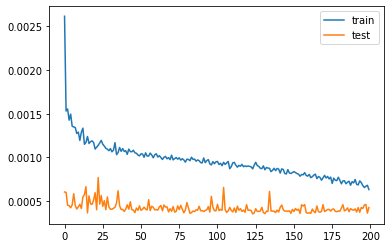

In [10]:
#plt.figure(figsize=(6,5),dpi=600)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test SMAPE: 0.326
Test RMSE: 5.971
Test RMSE1: 2.909


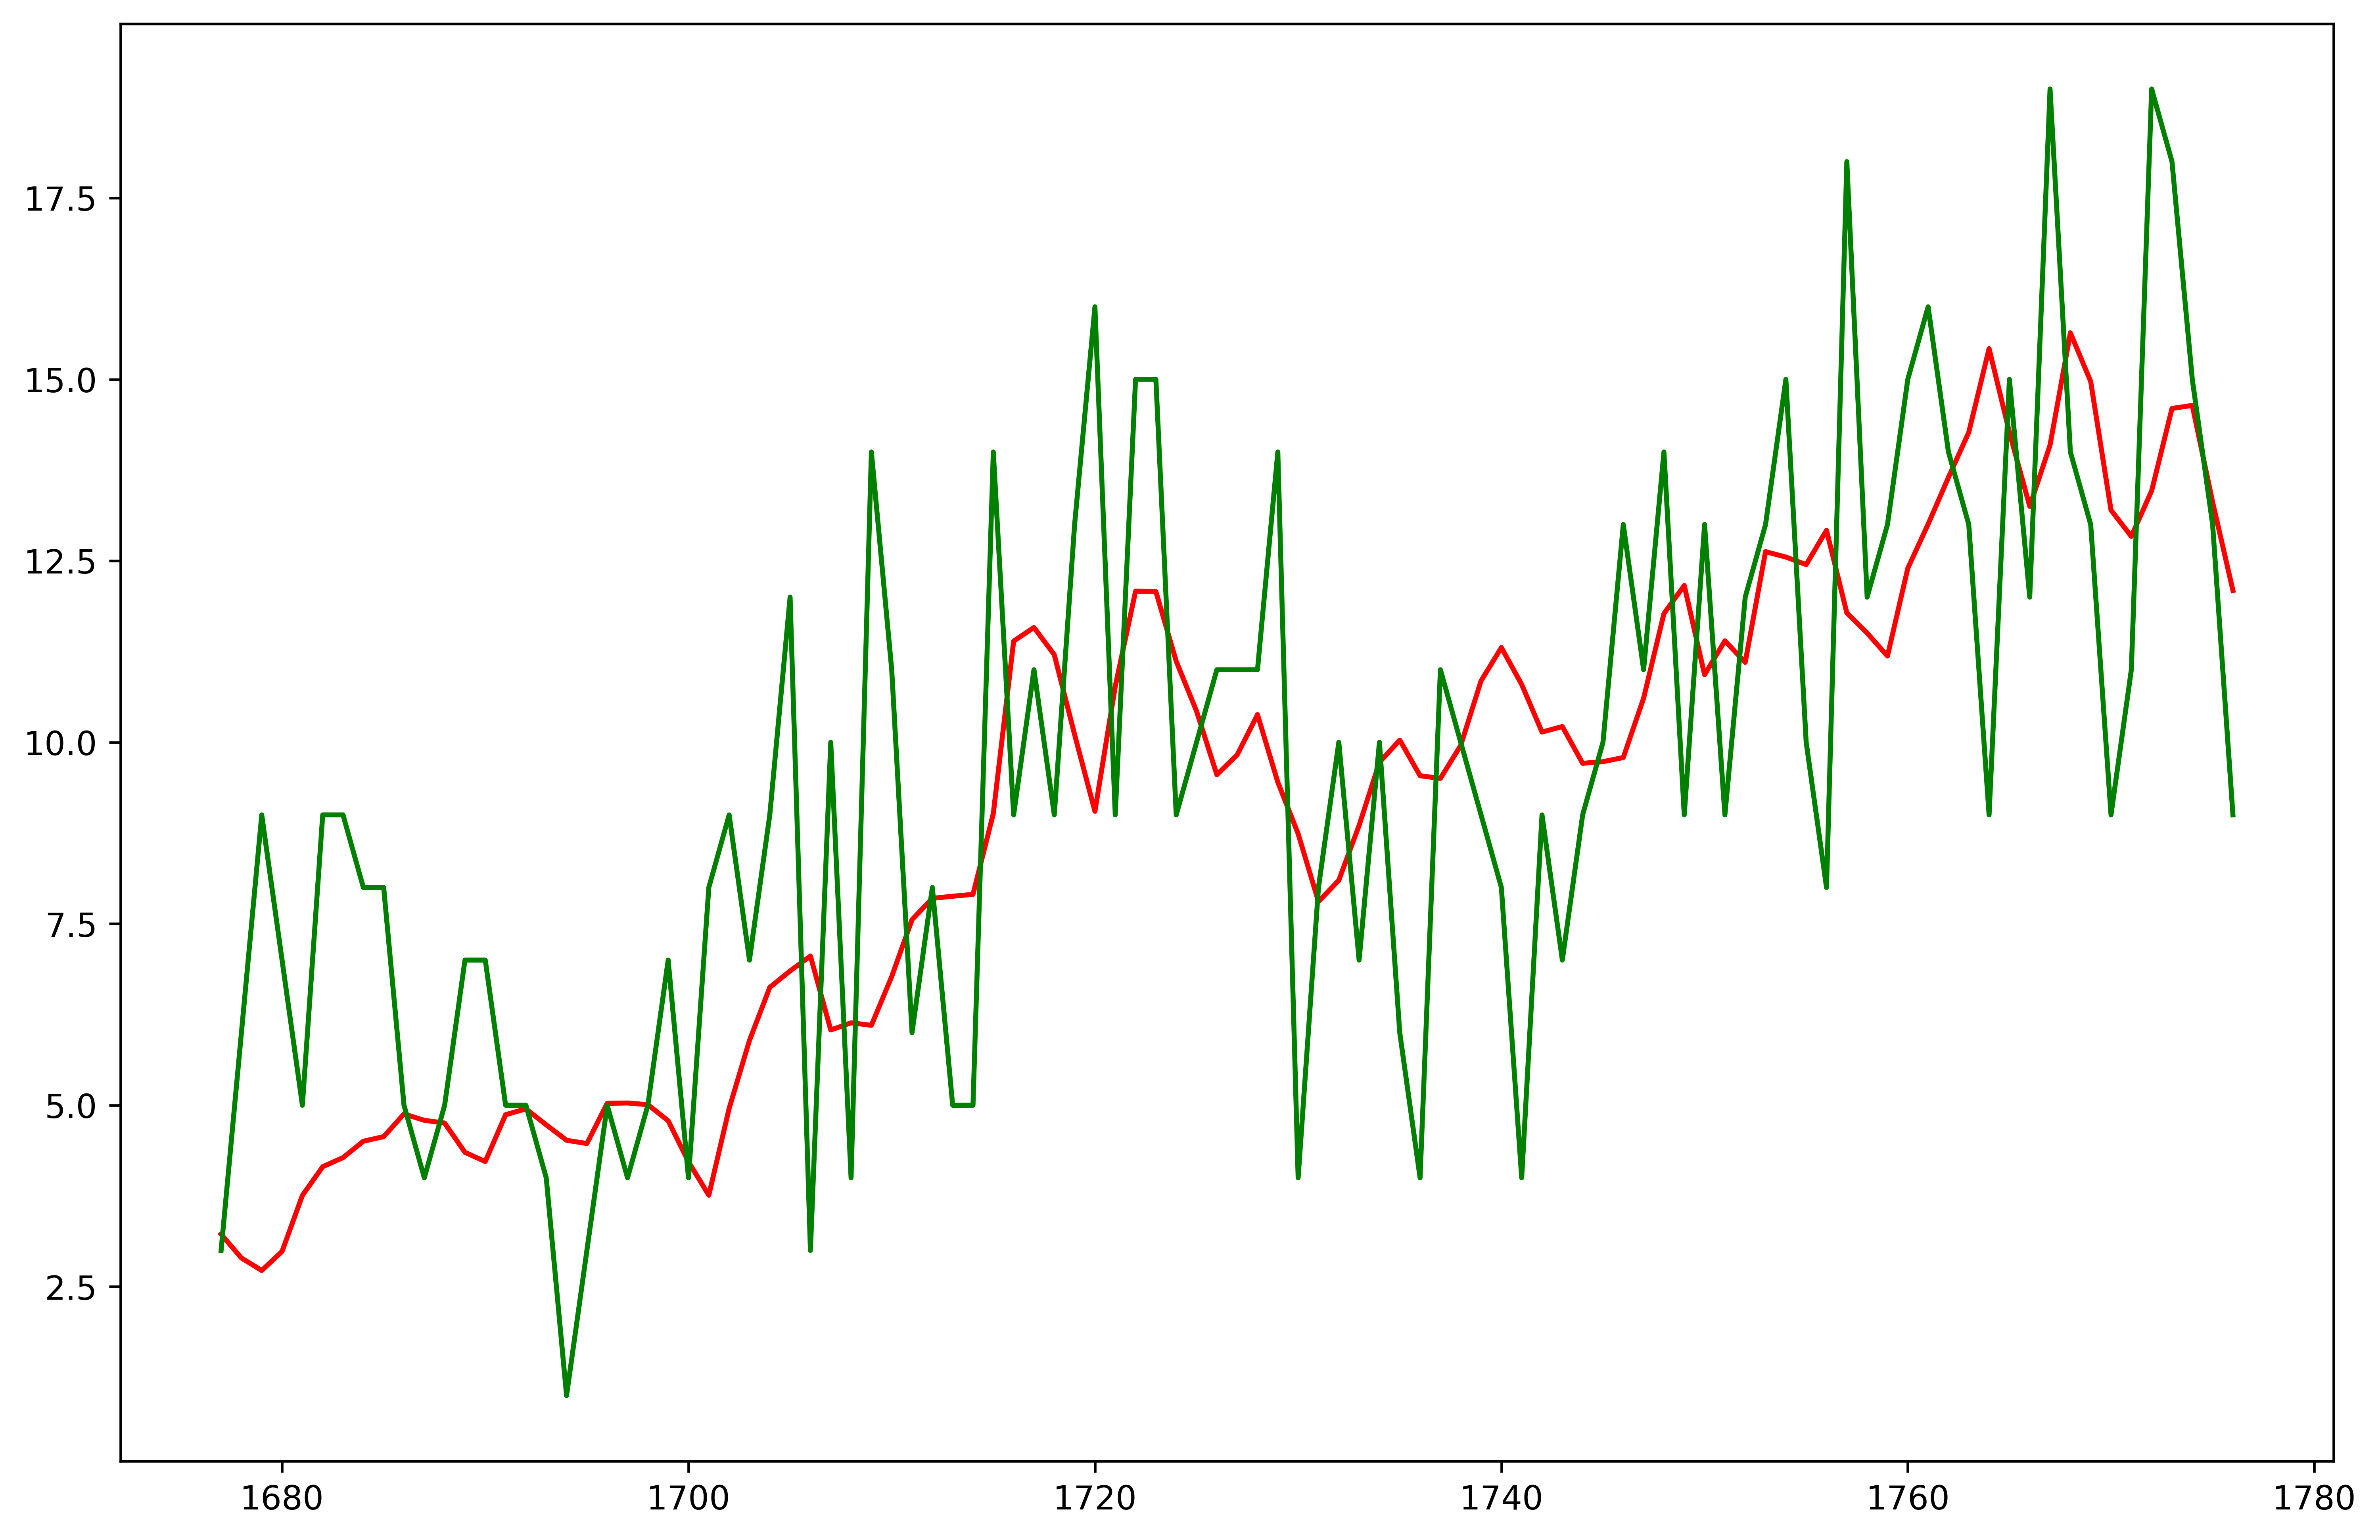

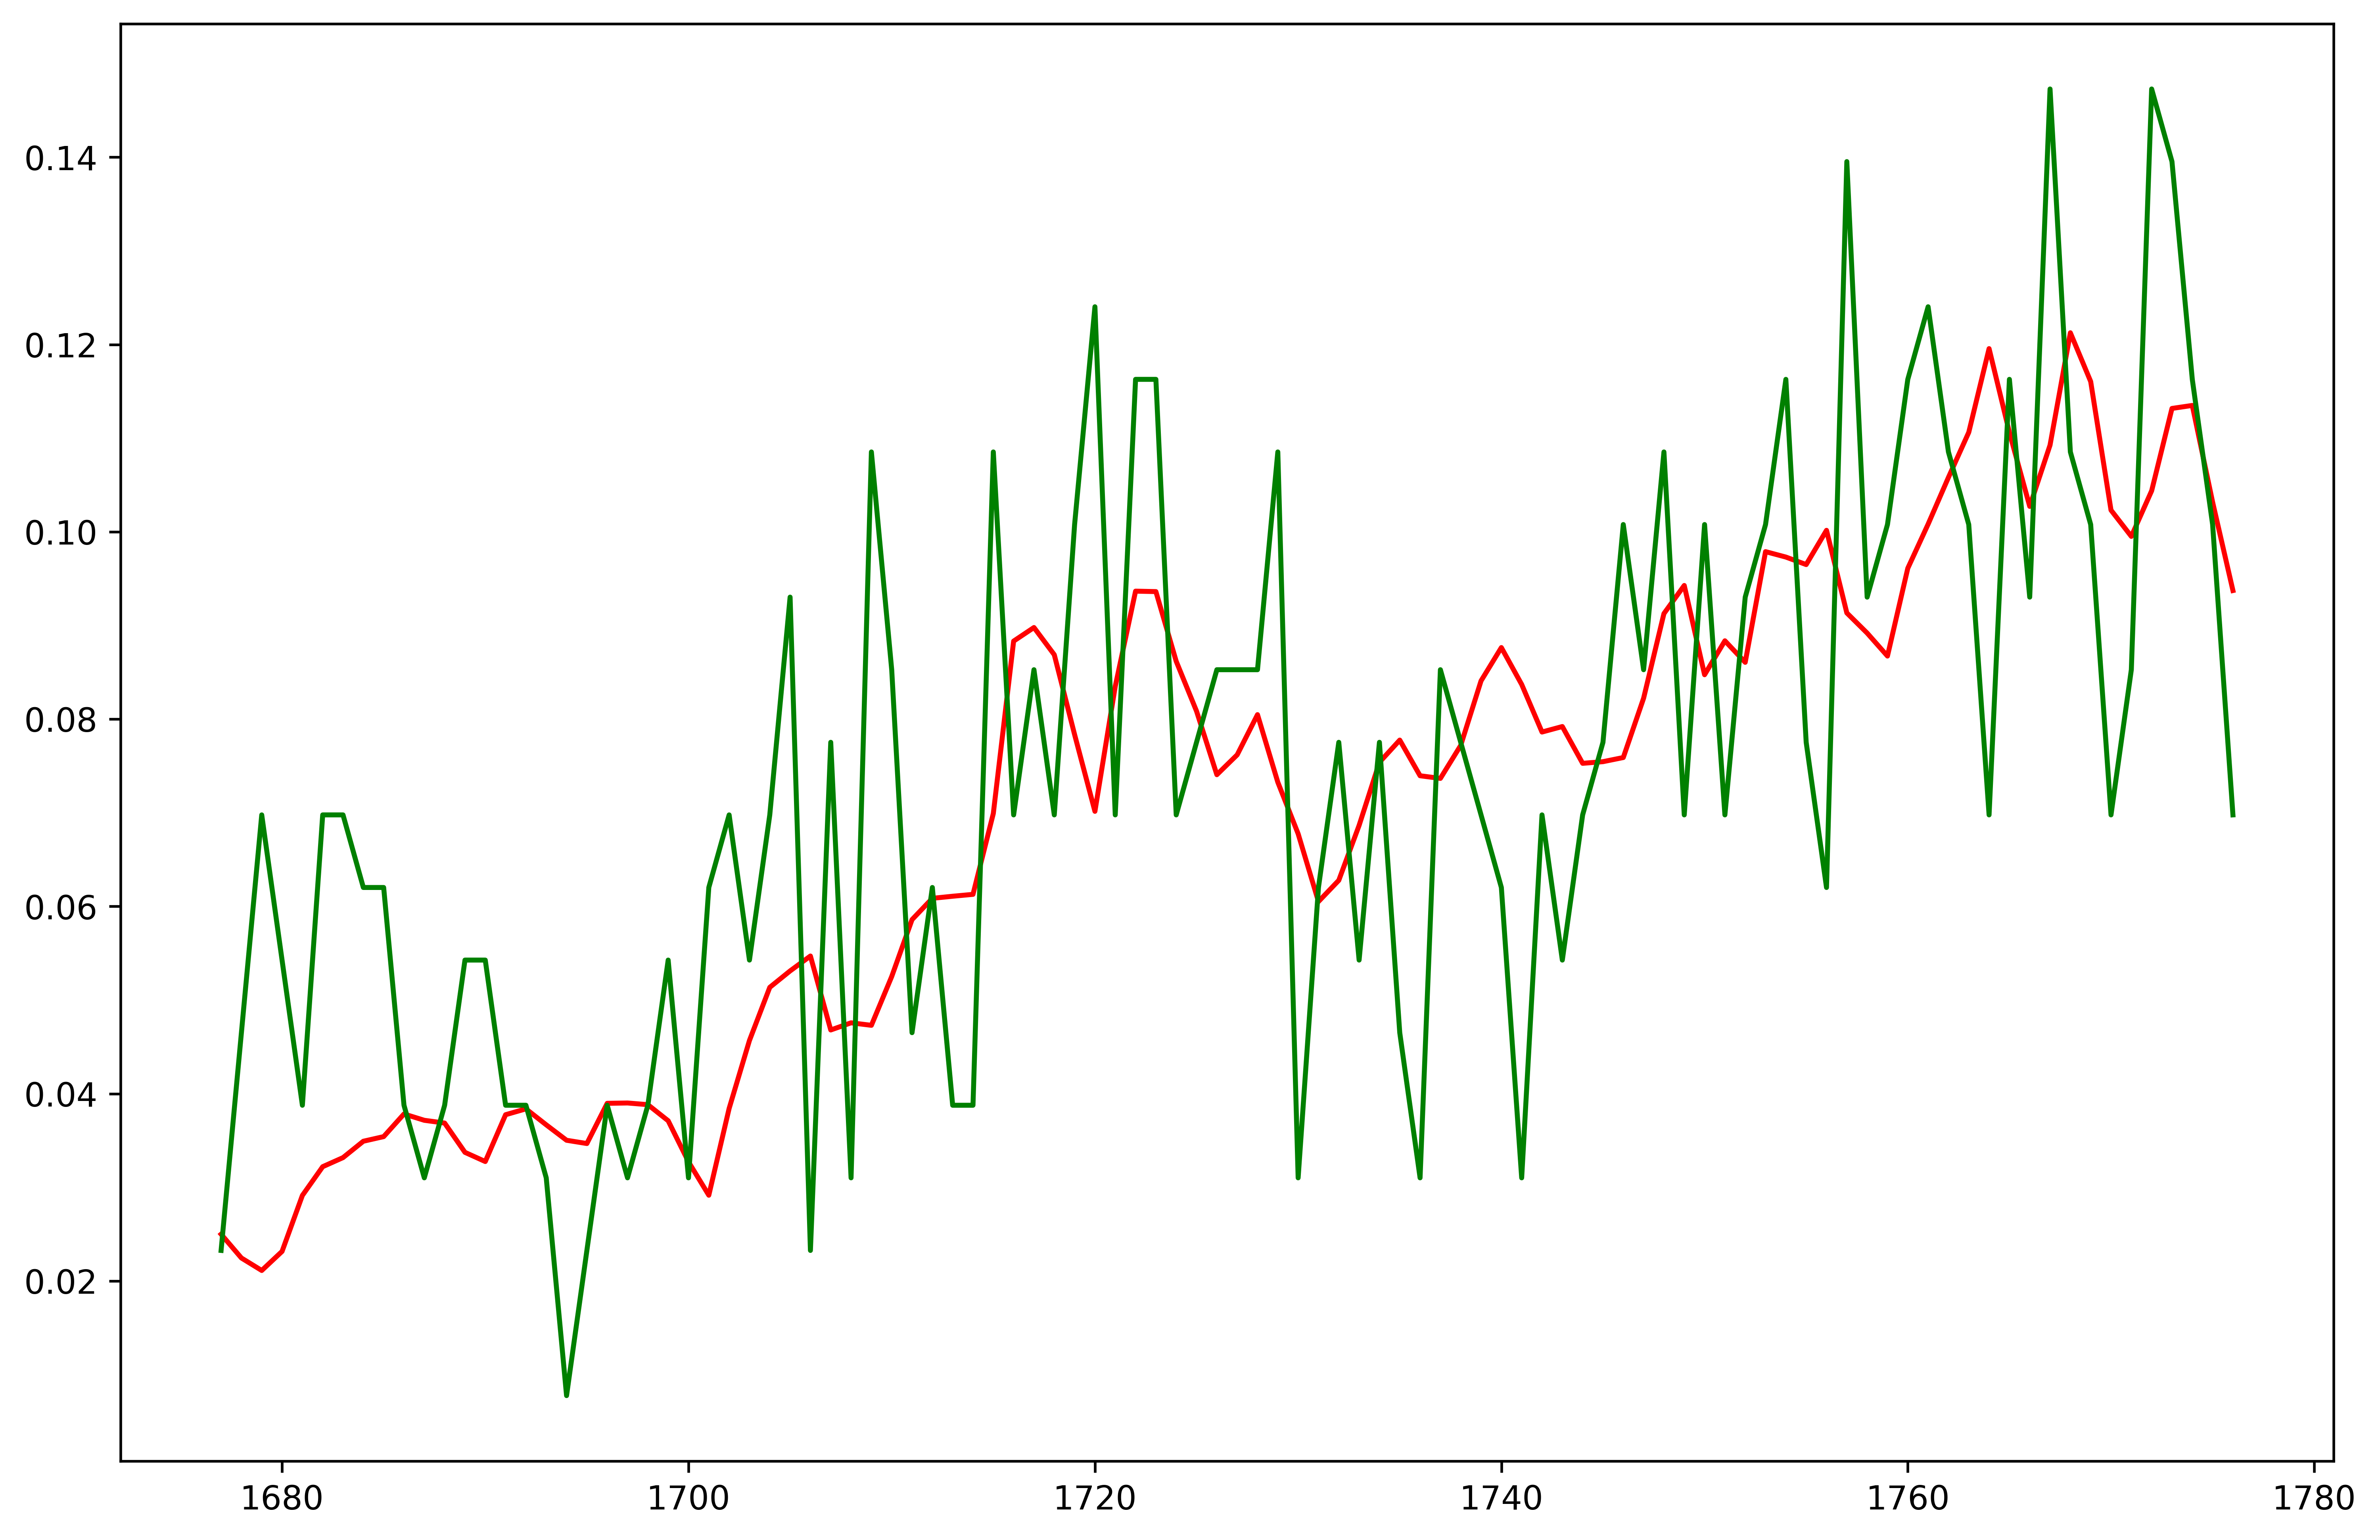

In [11]:
"""""""""""""""""""""
prediction：预测 
反归一化,这部收到sklearn API限制无法实现，只能尝试训练modle用归一化数据，而predict时用未归一化数据
并计算SMAPE，RMSE

"""""""""""""""""""""
import math
# make a prediction with scalerd data

y_pre = model.predict(x_test)  # 323*1 矩阵
#maxs,mins = data_new.max().max(),data_new.min().min()
maxs,mins = data_new.max().max(),data_new.min().min()
y_pre_unscaler= y_pre*(maxs-mins)+mins
#y_test_unscaler=scaler2.inverse_transform(y_test)
#y_pre_unscaler=scaler2.inverse_transform(y_pre)

"""""""""""""""""""""""
评价指标 SMAPE 和 RMSE

"""""""""""""""""""""""
import numpy as np
from math import sqrt
#from sklearn import metricskearas

# SMAPE和RMSE需要自己实现


def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())


#评价之前先反归一化：scaler

print('Test SMAPE: %.3f' % smape(y_test_unscaler,y_pre_unscaler))
print('Test RMSE: %.3f' % rmse(y_test_unscaler,y_pre_unscaler)) 
print('Test RMSE1: %.3f'% sqrt(mean_squared_error(y_test_unscaler, y_pre_unscaler)))

#y_pre1 = scaler.inverse_transform(y_pre).reshape(y_pre.shape)


"""""""""""""""""""""""
#plot 后100个值

"""""""""""""""""""""""
x_num=range(32,1777)
#plt.plot(x_num,y,'r')

#plt.figure(figsize=(12, 8),dpi=600)
#pre=plt.subplot(211)
#pre.plot(x_num[-100:],y_pre_unscaler[-100:],'r') 
#original=plt.subplot(212)
#original.plot(x_num[-100:],y_test_unscaler[-100:],'g') 

plt.figure(figsize=(12, 8),dpi=600)
plt.plot(x_num[-100:],y_pre_unscaler[-100:],'r',x_num[-100:],y_test_unscaler[-100:],'g')

plt.figure(figsize=(12, 8),dpi=600)
plt.plot(x_num[-100:],y_pre[-100:],'r',x_num[-100:],y_test[-100:],'g')